<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220823_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM
 - XGBoost 이후 나온 최신 부스팅 모델(리프 중심 트리 분할 방식)
 - 장점 : XGBoost보다 빠르고, 높은 정확도
 - 단점 : 해석이 어려움, 하이퍼파라미터 튜닝 어려움

# 카드 거래 내역 데이터셋을 이용한 이상거래 예측
- 알고리즘 : LightGBM
- 문제유형 : 분류
- 사용모델 : LGBMClassifier, train
- 평가지표 : 정확도, 혼동행렬, 분류 리포트, ROC_AUC 점수

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'http://media.githubusercontent.com/media/musthave-ML10/data_source/main/fraud.csv'
data = pd.read_csv(file_url)

In [ ]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


 - 변수가 22개 이므로 기본 출력 화면에 다담지 못해 중간에 ...으로 표시됨(기본 20개 컬럼만 출력)

In [ ]:
pd.options.display.max_columns = 40 # 40개 컬럼까지 출력되도록 설정

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

 - 평소와 달리 Non-null count가 나오지 않음 : 데이터가 너무 큰 경우 생략됨 → show_counts 매개변수로 강제로 보이게 함

In [ ]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

 - 결측치 없음
 - trans_data_trans_time은 날짜/시간 형태의 데이터 이지만 자료형이 object 형식
 - 날짜/시간 관련 함수를 적용하기 위해서는 datetime 형식으로 변환 필요

In [ ]:
round(data.describe(), 2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


 - amt, zip 변수의 max값이 급격히 높음 → 아웃라이어 의심
 - is_fraud 사기여부 변수의 평균값이 0.01로 이상거래인 경우가 1%인 데이터 → 정확도가 99%인 모델을 만들더라도 좋은 모델이라는 보장이 없다
 - 한쪽으로 치우친 데이터 : 비대칭 데이터

## 전처리 : 데이터 클리닝
 - 불필요한 변수 제외

In [ ]:
data.drop(['first','last','street','city','state','zip','trans_num',
           'unix_time','job','merchant'], axis=1, inplace=True)

 - trans_date_time 변수를 datetime 형으로 수정

In [ ]:
data['trans_date_trans_time'] = data['trans_date_trans_time'].astype('datetime64[ns]')
# pd.to_datetime(data['trans_date_trans_time'']) # datetime으로 바꾸는 다른 방법

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   lat                    float64       
 6   long                   float64       
 7   city_pop               int64         
 8   dob                    object        
 9   merch_lat              float64       
 10  merch_long             float64       
 11  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 169.6+ MB


## 전처리 : 피처 엔지니어링
 - 기존 거래 패턴에서 벗어나는 경우를 감지

  > 갑자기 다른 지역에서 고액의 물건을 구매

  > 한 번도 이용한적 없는 종류의 매장에서 고액의 물건을 구매

### 결제 금액
 - 평소와 다른 고액 결제
 - Z점수 사용(표준값, 표준점수)

  > 특정값이 정규분포 범위에서 어느 수준에 위치하는가

  > 평균과 표준편차 활용

In [ ]:
# cc_num 변수 : 카드번호로써 각 개인 id 처럼 활용
# amt 변수 : 거래 금액
data.groupby('cc_num').agg(['mean','std'])['amt']
# 각 개인별 모든 변수에 대해 평균, 표준편차를 구하고 그 중 'amt'변수에 대한 평균, 표준편차만 가져옴

,mean,std
cc_num,,
60416207185,59.257796,142.869746
60422928733,65.483159,92.042844
60423098130,96.376084,1000.693872
60427851591,107.487550,131.014534
60487002085,64.096925,153.207660
...,...,...
4958589671582726883,67.205600,137.504101
4973530368125489546,75.789148,258.847061
4980323467523543940,70.709484,119.903167


In [ ]:
amt_info = data.groupby('cc_num').agg(['mean','std'])['amt'].reset_index()

In [ ]:
amt_info.head()

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660


 - mean, std 변수를 cc_num을 키값으로 기존 data에 merge

In [ ]:
data.merge(amt_info) # on='cc_num' 생략가능 : 키 값이 하나인 경우 자동으로 찾아줌

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,mean,std
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,89.408743,127.530101
1,2019-01-01 16:53:34,2703186189652095,kids_pets,114.79,F,36.0788,-81.1781,3495,1988-03-09,35.083586,-80.625951,0,89.408743,127.530101
2,2019-01-01 23:02:37,2703186189652095,kids_pets,16.55,F,36.0788,-81.1781,3495,1988-03-09,35.532409,-82.170017,0,89.408743,127.530101
3,2019-01-03 01:40:38,2703186189652095,misc_net,27.70,F,36.0788,-81.1781,3495,1988-03-09,35.315851,-80.666723,0,89.408743,127.530101
4,2019-01-03 15:24:11,2703186189652095,entertainment,43.72,F,36.0788,-81.1781,3495,1988-03-09,36.956094,-80.343520,0,89.408743,127.530101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-22 22:05:48,2242176657877538,shopping_pos,1041.51,M,34.6323,-89.8855,14462,1959-03-03,34.573471,-89.911011,1,686.806000,419.152774
1852390,2020-12-22 22:18:07,2242176657877538,shopping_pos,868.09,M,34.6323,-89.8855,14462,1959-03-03,34.091227,-90.390612,1,686.806000,419.152774
1852391,2020-12-22 22:31:48,2242176657877538,shopping_net,1039.42,M,34.6323,-89.8855,14462,1959-03-03,34.628434,-90.284780,1,686.806000,419.152774
1852392,2020-12-22 23:06:03,2242176657877538,grocery_pos,289.27,M,34.6323,-89.8855,14462,1959-03-03,34.746063,-90.401093,1,686.806000,419.152774


In [ ]:
data = data.merge(amt_info)

In [ ]:
(data['amt'] - data['mean']) / data['std'] # Z score 계산

0         -0.662108
1          0.199022
2         -0.571306
3         -0.483876
4         -0.358259
             ...   
1852389    0.846240
1852390    0.432501
1852391    0.841254
1852392   -0.948427
1852393    0.189845
Length: 1852394, dtype: float64

In [ ]:
data['amt_z_score'] = (data['amt'] - data['mean']) / data['std'] # Z score 별도의 변수로 생성

In [ ]:
data[['amt','mean','std','amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,114.79,89.408743,127.530101,0.199022
2,16.55,89.408743,127.530101,-0.571306
3,27.70,89.408743,127.530101,-0.483876
4,43.72,89.408743,127.530101,-0.358259


In [ ]:
data.drop(['mean','std'], axis=1, inplace=True) # amt_z_score 변수를 생성했으니, mean, std변수는 제거

### 범주
 - 각 개인마다(cc_num) 어떤 범주에(category) 얼마만큼의 금액을 쓰는지(amt)

In [ ]:
data.groupby(['cc_num','category']).agg(['mean','std'])['amt'].reset_index()

,cc_num,category,mean,std
0,60416207185,entertainment,51.838855,65.485714
1,60416207185,food_dining,26.737097,46.382603
2,60416207185,gas_transport,59.779429,15.758267
3,60416207185,grocery_net,52.152973,17.694871
4,60416207185,grocery_pos,101.557761,21.894156
...,...,...,...,...
13166,4992346398065154184,misc_pos,60.003043,167.226191
13167,4992346398065154184,personal_care,48.777227,49.523818
13168,4992346398065154184,shopping_net,86.280136,217.047242
13169,4992346398065154184,shopping_pos,64.213333,169.239073


In [ ]:
category_info = data.groupby(['cc_num','category']).agg(['mean','std'])['amt'].reset_index()

In [ ]:
data = data.merge(category_info, on=['cc_num','category'], how='left') # 키값에 cc_num과 category 순서로 입력

In [ ]:
data['cat_z_score'] = (data['amt'] - data['mean']) / data['std']
data.drop(['mean','std'], axis=1, inplace=True)

### 거리
 - 고객위치와 상점위치간의 거리 계산
 - 거리에 대한 Z점수 활용 → 기존 패턴에서 벗어난 거래 감지 가능

 - 두 지점 거리 계산에 geopy 라이브러리 사용
  
   > geopy 라이브러리의 distance 모듈

   >
    ```
    geopy.distance.distance((위도1, 경도1), (위도2, 경도2)).km
    # lat(위도), long(경도)
    ```



In [ ]:
import geopy.distance

In [ ]:
zip(data['merch_lat'], data['merch_long'])

In [ ]:
data['merch_coord'] = pd.Series(zip(data['merch_lat'], data['merch_long'])) # 상점 위치
data['cust_coord'] = pd.Series(zip(data['lat'], data['long']))

 - geopy.distance.distance() 함수를 DataFrame에 apply()로 적용할 예정

In [ ]:
# geopy.distance.distance(data['merch_coord'], data['cust_coord']) # 에러 발생
# ValueError: When creating a Point from sequence, it must not have more than 3 items.

In [ ]:
geopy.distance.distance(data['merch_coord'][0], data['cust_coord'][0]) # 한 건씩 계산되는 함수(시리즈간의 브로드캐스팅 계산이 안되네)

Distance(78.77382075373654)

 - apply()를 활용하여 복수의 변수를 활용한 func를 적용 + DataFrame의 여러 데이터를 한번에 처리할 수 있다

 - DataFrame.apply()에서 DataFrame을 인자로 받을때는 lambda x를 활용하면, 복수의 변수를 활용하는 func를 적용할 수 있다

In [ ]:
import time

start_time = time.time()
data['distance'] = data.apply(lambda x : geopy.distance.distance(x['merch_coord'], x['cust_coord']), axis=1)
# data['distance'] = data.apply(lambda x : geopy.distance.distance(x['merch_coord'], x['cust_coord']).km, axis=1) # km를 설정해주면 float으로 인식
end_time = time.time()
print(end_time - start_time)

1660892229.9118953 1660891738.9733617


In [ ]:
# data['distance']이 object 형식으로 agg()통한 계산에서 생략되버림
# data['distance']를 처음부터 distance().km 설정을 하거나, 이후 astype()을 통해 float 형식으로 변경
data['distance'] = data['distance'].astype('str').str[:-3].astype('float64')

In [ ]:
distance_info = data.groupby('cc_num').agg(['mean','std'])['distance'].reset_index() # cc_num별 거리정보 계산
data = data.merge(distance_info, on='cc_num', how='left')  # 데이터 합치기
data['distance_z_score'] = (data['distance']-data['mean']) / data['std'] # Z-score 계산
data.drop(['mean','std'], axis=1, inplace=True) # 변수 제거
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance,distance_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821,0.030974
1,2019-01-01 16:53:34,2703186189652095,kids_pets,114.79,F,36.0788,-81.1781,3495,1988-03-09,35.083586,-80.625951,0,0.199022,1.022751,"(35.083586, -80.625951)","(36.0788, -81.1781)",121.231332,1.442813
2,2019-01-01 23:02:37,2703186189652095,kids_pets,16.55,F,36.0788,-81.1781,3495,1988-03-09,35.532409,-82.170017,0,-0.571306,-0.847664,"(35.532409, -82.170017)","(36.0788, -81.1781)",108.226552,1.010365
3,2019-01-03 01:40:38,2703186189652095,misc_net,27.70,F,36.0788,-81.1781,3495,1988-03-09,35.315851,-80.666723,0,-0.483876,-0.492467,"(35.315851, -80.666723)","(36.0788, -81.1781)",96.477834,0.619685
4,2019-01-03 15:24:11,2703186189652095,entertainment,43.72,F,36.0788,-81.1781,3495,1988-03-09,36.956094,-80.343520,0,-0.358259,-0.665418,"(36.956094, -80.34352)","(36.0788, -81.1781)",122.740761,1.493006


### 나이 구하기
 - Pandas의 Series에서 dt함수를 사용하면 해당 값에 대 한 년, 월, 일 등을 분리해낼 수 있음

In [ ]:
from datetime import datetime

In [ ]:
# datetime.strptime(data['dob'], "%m/%d/%Y") # strptime()의 파라미터에 시리즈가 들어갈 수 없음
# TypeError: strptime() argument 1 must be str, not Series

In [ ]:
data['dob'] # 1999-01-01 의 object 형식을 datetime 으로 바꿔야 함

0          1988-03-09
1          1988-03-09
2          1988-03-09
3          1988-03-09
4          1988-03-09
              ...    
1852389    1959-03-03
1852390    1959-03-03
1852391    1959-03-03
1852392    1959-03-03
1852393    1959-03-03
Name: dob, Length: 1852394, dtype: object

 - 1900-01-01 등의 object형식의 Series를 datetime 형식으로 변경하는 방법

  > 첫번째방법 : pandas 활용(포맷지정은 선택사항, 간편)
```
pd.to_datetime(Series)
```
  > 두번째방법 : datetime 모듈 활용(포맷지정 필수, 빠른 연산)
```
from datetime import datetime
Series.apply(lambda x: datetime.strptime(x, format)
```
 > ※ 주의사항 : datetime.strptime(Series, format) 오류 → Series 사용불가


In [ ]:
# 첫번째방법
pd.to_datetime(data['dob'])

0         1988-03-09
1         1988-03-09
2         1988-03-09
3         1988-03-09
4         1988-03-09
             ...    
1852389   1959-03-03
1852390   1959-03-03
1852391   1959-03-03
1852392   1959-03-03
1852393   1959-03-03
Name: dob, Length: 1852394, dtype: datetime64[ns]

In [ ]:
# 두번째방법
data['dob'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

0         1988-03-09
1         1988-03-09
2         1988-03-09
3         1988-03-09
4         1988-03-09
             ...    
1852389   1959-03-03
1852390   1959-03-03
1852391   1959-03-03
1852392   1959-03-03
1852393   1959-03-03
Name: dob, Length: 1852394, dtype: datetime64[ns]

In [ ]:
# datetime 형식의 Series에서 dt.year 사용가능
data['year'] = data['dob'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")).dt.year

In [ ]:
data.drop(['cc_num','lat','long','merch_lat','merch_long','dob','merch_coord','cust_coord'], axis=1, inplace=True)
data.head()

,trans_date_trans_time,category,amt,gender,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,year
0,2019-01-01 00:00:18,misc_net,4.97,F,3495,0,-0.662108,-0.688297,78.773821,0.030974,1988
1,2019-01-01 16:53:34,kids_pets,114.79,F,3495,0,0.199022,1.022751,121.231332,1.442813,1988
2,2019-01-01 23:02:37,kids_pets,16.55,F,3495,0,-0.571306,-0.847664,108.226552,1.010365,1988
3,2019-01-03 01:40:38,misc_net,27.70,F,3495,0,-0.483876,-0.492467,96.477834,0.619685,1988
4,2019-01-03 15:24:11,entertainment,43.72,F,3495,0,-0.358259,-0.665418,122.740761,1.493006,1988


### 새 변수 만들기
 - object 변수인 category와 gender는 더미 변수로 변환하여 활용

In [ ]:
data = pd.get_dummies(data, columns=['category','gender'], drop_first=True)

 - trans_date_trans_time은 예측에는 필요 X
 - 훈련셋을 분리시키는데 활용
 - 모델링에는 활용하지 않으므로 index로 설정

In [ ]:
data.set_index('trans_date_trans_time', inplace=True)
data.head()

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,year,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,1988,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-01-01 16:53:34,114.79,3495,0,0.199022,1.022751,121.231332,1.442813,1988,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2019-01-01 23:02:37,16.55,3495,0,-0.571306,-0.847664,108.226552,1.010365,1988,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2019-01-03 01:40:38,27.70,3495,0,-0.483876,-0.492467,96.477834,0.619685,1988,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-01-03 15:24:11,43.72,3495,0,-0.358259,-0.665418,122.740761,1.493006,1988,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 최종 DataFrame 저장
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/lgbdata.csv')            # DataFrame 저장(자동으로 reset_index()가 적용됨)

# 저장된 DataFrame 로드
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lgbdata.csv',       # DataFrame 로드
                   index_col='trans_date_trans_time')

## 모델링 및 평가하기
 - 지금까지 발생한 거래 데이터를 기반으로(과거)
 - 앞으로 일어나는 거래에 대한 이상여부 예측
 - 따라서, train_test_split()사용 X
 - 특정 날짜를 기준으로 훈련셋/시험셋 나눔

  > 2020년7월~12월 데이터를 시험셋

In [4]:
train = data[data.index < '2020-07-01'] # 훈련셋 설정
test = data[data.index >= '2020-07-01'] # 시험셋 설정

In [ ]:
len(test) / len(data) # 시험셋 비율

0.2837738623640543

In [5]:
X_train = train.drop('is_fraud', axis=1)
X_test = test.drop('is_fraud', axis=1)
y_train = train['is_fraud']
y_test = test['is_fraud']

In [6]:
import lightgbm as lgb

In [ ]:
# 사이킷런 래퍼 모듈 활용하여 모델생성 및 훈련(fit())
# model_1 = lgb.LGBMClassifier(random_state=100)
# model_1.fit(X_train, y_train) # 아무런 하이퍼파라미터 지정없이(사이킷런 기본하이퍼파라미터 적용) 훈련
pred_1 = model_1.predict(X_test)

In [7]:
import joblib # 모델 저장을 위한 라이브러리

# 모델 저장
# joblib.dump(model_1, '/content/drive/MyDrive/Colab Notebooks/lgb_model_1.pkl') # 모델 저장하기
# 모델 로드
model_1 = joblib.load('/content/drive/MyDrive/Colab Notebooks/lgb_model_1.pkl') # 

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:
accuracy_score(y_test, pred_1)

0.9969143611567151

 - 정확도 : 99.6% → 종속변수가 한쪽으로 치우친 비대칭 데이터이므로 높은 예측률이 의미 없음
 - 이미 is_fraud가 0인 경우가 99%

In [ ]:
print(confusion_matrix(y_test, pred_1))

[[522807    842]
 [   780   1232]]


 - 1종오류(FP, 842)와 2종오류(FN, 830) 비슷한 수준
 - 1종오류 : 이상거래라고 판단했으나 실제 정상거래

  > 예민한 반응으로 거래를 지연시키며 고객이 불편
 - 2종오류 : 정상거래라고 판단했으나 실제 이상거래

  > 정상 거래 건을 안정적으로 처리하겠지만, 이상거래를 통과시킬 수 있음

 - 고객이 번거롭더라도 이상거래를 조금 더 포착하는것이 중요

In [ ]:
print(classification_report(y_test, pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.59      0.61      0.60      2012

    accuracy                           1.00    525661
   macro avg       0.80      0.81      0.80    525661
weighted avg       1.00      1.00      1.00    525661



 - 모델이 예민하게 반응한다는 것의 의미를 구체적으로 알아보자
 - 이진분류는 0, 1을 예측한다.
 - 예측값들은 실제 0.2322, 0.6782 같은 소수점 형태
 - 다만, 0.5를 기준으로 반올림하여, 최종적으로 0과 1로 결정된다.
 - 이 기준점이 민감도를 결정한다.
 - 예로, 0.2를 기준으로 하면 0.2보다 큰 값은 모두 1로 분류 되어 매우 민감하게 반응

In [ ]:
proba_1 = model_1.predict_proba(X_test)

In [ ]:
proba_1

array([[1.00000000e+00, 2.85059673e-18],
       [9.99569189e-01, 4.30811101e-04],
       [9.79779767e-01, 2.02202334e-02],
       ...,
       [4.84967527e-08, 9.99999952e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]])

In [ ]:
proba_1[:, 1] # 1에 대한 예측 결과만 출력

array([2.85059673e-18, 4.30811101e-04, 2.02202334e-02, ...,
       9.99999952e-01, 1.00000000e+00, 1.00000000e+00])

In [ ]:
proba_1 = proba_1[:, 1] # 1일 가능성 예측값만 사용하므로 덮어씀

In [ ]:
proba_int1 = (proba_1 > 0.2).astype('int') # 0.2 기준으로 분류(예민)
proba_int2 = (proba_1 > 0.8).astype('int') # 0.8 기준으로 분류(덜예민)

 - True/False인 불리언을 .astype('int')로 1/0으로 변환
```
np.array([False, True]).astype('int')
 > array([0, 1])
```




In [ ]:
print(confusion_matrix(y_test, proba_int1))

[[522228   1421]
 [   635   1377]]


In [ ]:
print(classification_report(y_test, proba_int1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.49      0.68      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.75      0.84      0.79    525661
weighted avg       1.00      1.00      1.00    525661



 - 0.2를 기준점으로 한 결과
 - 1종오류(1421) 증가, TP(1377) 증가
 - 정밀도는 기존보다 떨어지고, 재현율은 개선

In [ ]:
print(confusion_matrix(y_test, proba_int2))

[[523217    432]
 [  1080    932]]


In [ ]:
print(classification_report(y_test, proba_int2)) # 분류 리포트 확인

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.68      0.46      0.55      2012

    accuracy                           1.00    525661
   macro avg       0.84      0.73      0.78    525661
weighted avg       1.00      1.00      1.00    525661



 - 0.8을 기준점으로 한 결과
 - TP(932) 감소, 1종오류(432) 감소(개선), 2종오류(1080) 증가
 - 정상거래건을 이상거래로 잘못 의심하는(1종오류) 경우는 줄었음 → **정밀도 증가**
 - 이상거래를 놓치는(2종오류) 경우가 늘었음 → **재현율**

 - 이 분석의 목적에 따라 재현율을 가장 중요하게 보아야 겠지만, 그렇다고 정밀도가 지나치게 낮아지는 것도 조심해야 함 → 적절한 기준점 선정

 - 이 경우 AUC 지표 활용 : ROC곡선의 하부 면적을 의미

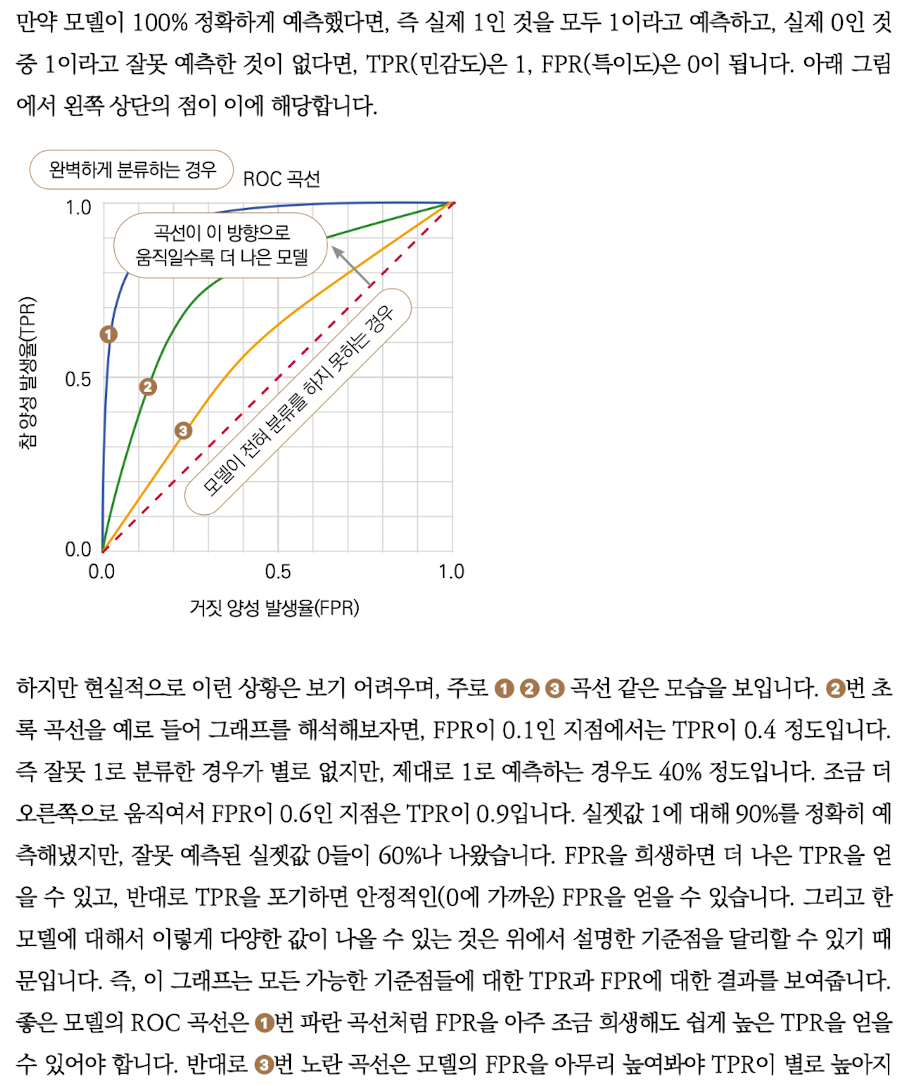

 - FPR = 0.1 : 잘못 1로 예측 10%
 - TPR = 0.4 : 제대로 1로 예측 40%

 - 1번 파란곡선처럼 FPR을 조금만 희생해도 쉽게 높은 TPR을 얻을 수 있는 것이 중요(큰 기울기)

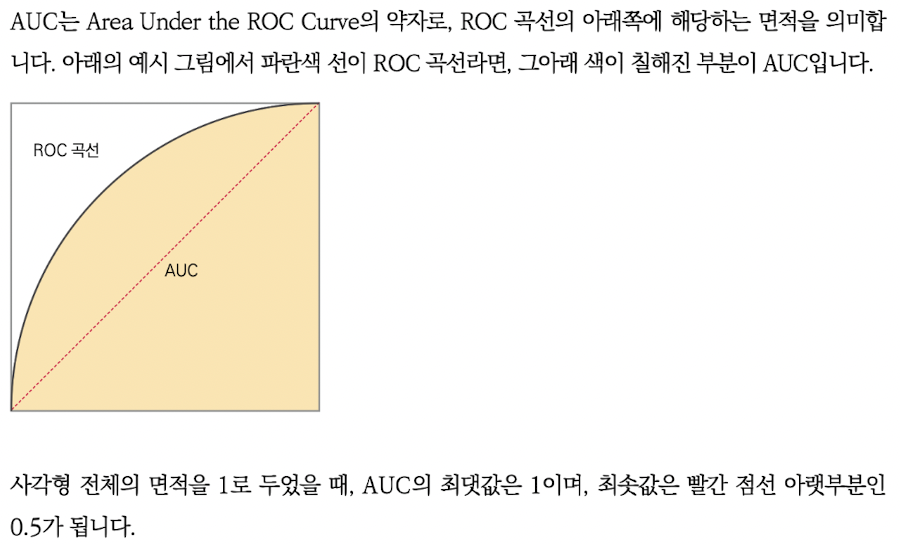

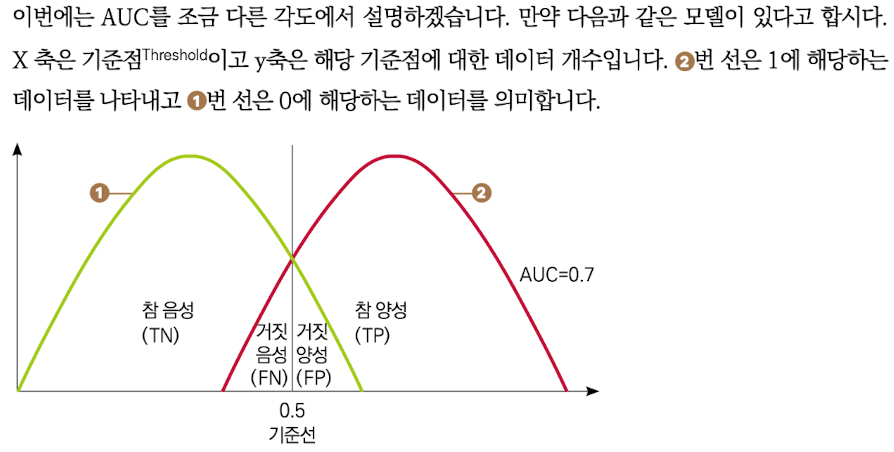

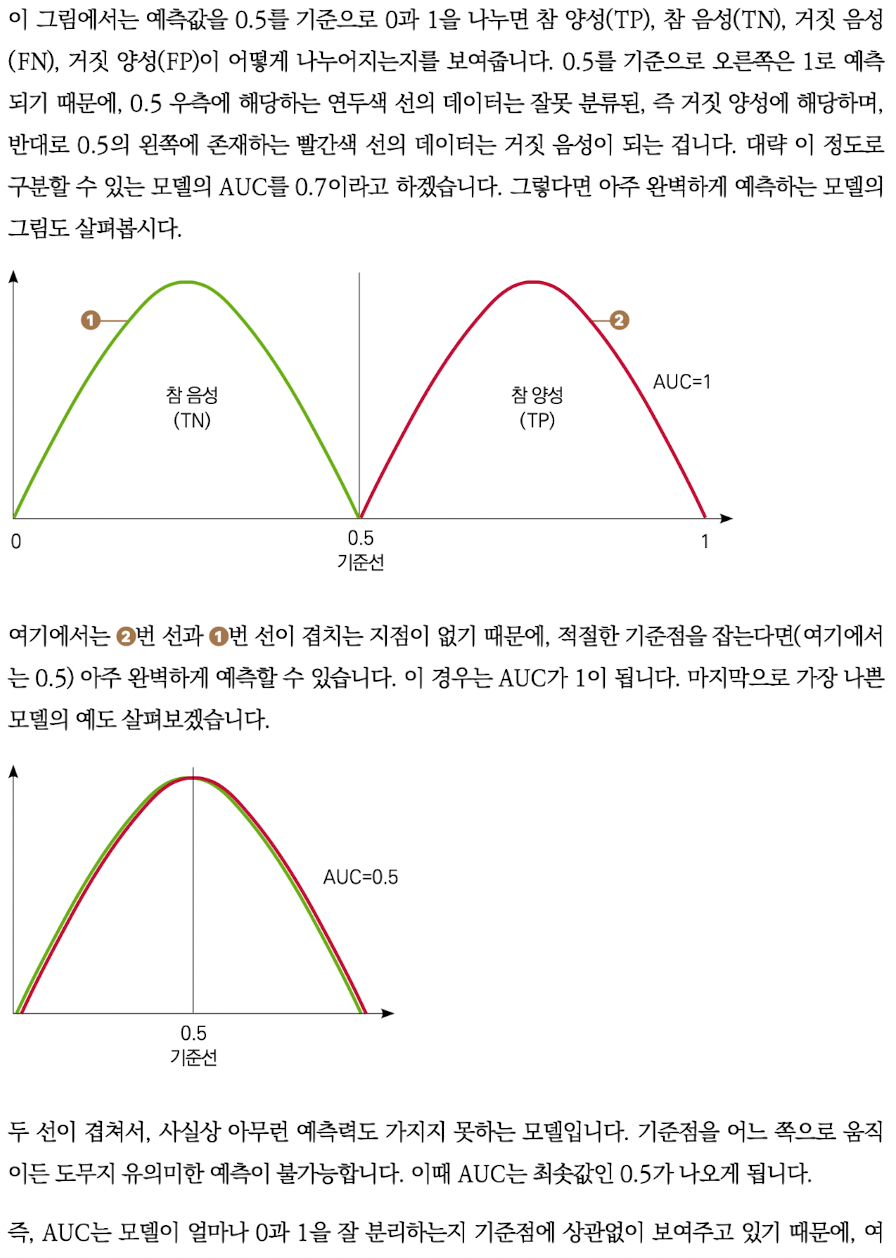

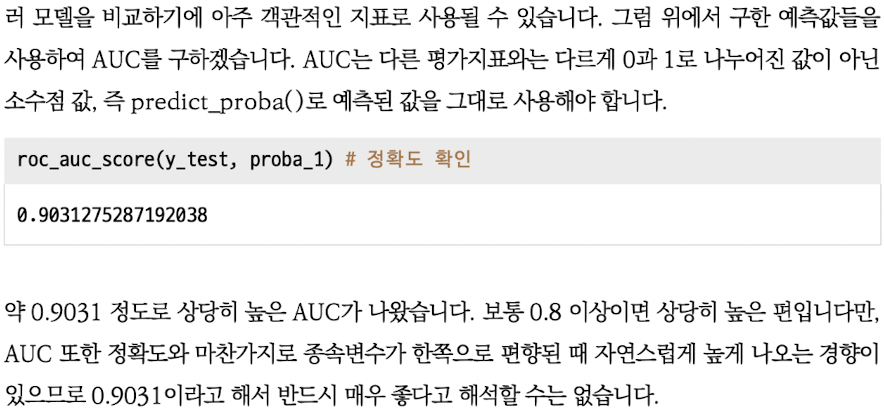

 - AUC는 다른 평가지표와는 달리 0과 1로 나누어진 값이 아닌 소수점 값, 즉 predict_proba()로 예측된 값을 그대로 사용해야 함

## 하이퍼파라미터 튜닝 : 랜덤 그리드 서치
 - 기존 그리드 서치와 유사하나, 모든 조합이 아닌 랜덤으로 일부만을 조합
 - 짧은 시간에 다양하게 활용하고자 함

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
params = {'n_estimators':[100,500],
          'learning_rate':[0.01,0.3],
          'lambda_l1':[0,10,20],        # L1 정규화
          'lambda_l2':[0,10,20],        # L2 정규화
          'max_depth':[5,10],
          'subsample':[0.6,0.8]}

 - 선형 회귀 모델에서의 L1, L2 정규화를 예로,
 - 기울기(w)에 패널티를 부가하여 너무 큰 기울기가 나오지 않도록 강제함 → 오버피팅 방지

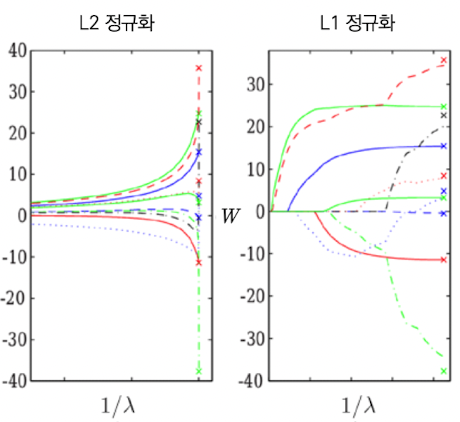

 - 람다 : 패널티에 대한 가중치로써, 직접 정의할 수 있는 하이퍼파라미터
 - 람다가 커짐에 따라 계수의 절대값이 감소
 - x축이 1/람다 즉, 왼쪽으로 갈수록 큰 람다
 - L2 정규화에서는, 람다가 커지면 계수가 0에 가까워지지만 0이 되지는 않으므로 모든 변수들이 모델에 반영됨
 - L1 정규화에서는, 람다가 커지면 특정 계수가 0이 되어버려 불필요한 변수가 제거되는 **피처 셀렉션 효과**
 

In [48]:
model_2 = lgb.LGBMClassifier(random_state=100)
rs = RandomizedSearchCV(model_2, param_distributions=params,
                        n_iter=1,   # 전체 파라미터 조합 중 몇 개를 사용할 것인지
                        scoring='roc_auc',
                        random_state=100, n_jobs=-1)
# 바로 model_2.fit() 하지 않고, RandomizedSearchCV(model_2, param_dist) 하는 이유
# 1)최적의 하이퍼파라미터를 찾고, 2)모델에 자동 적용하기 위함

In [49]:
import time
start = time.time()
rs.fit(X_train, y_train) # 학습
print(time.time() - start) # 총 소요시간 확인

45.746397495269775


In [50]:
# 모델 훈련에 시간이 많이 소요되므로 훈련된 모델을 저장/로드
import joblib # 모델 저장을 위한 라이브러리

# 모델 저장
joblib.dump(rs, '/content/drive/MyDrive/Colab Notebooks/lgb_rs.pkl') # 모델 저장하기
# 모델 로드
# rs = joblib.load('/content/drive/MyDrive/Colab Notebooks/lgb_rs.pkl') # 

['/content/drive/MyDrive/Colab Notebooks/lgb_rs.pkl']

In [51]:
rs.best_params_ # best_params : 최적의 성능을 내는 파라미터 조합

{'subsample': 0.6,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.3,
 'lambda_l2': 0,
 'lambda_l1': 0}

In [78]:
model_2.get_params() # LGBMClassifier와 RandomizedSearchCV의 파라미터는 다르다

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 100,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

 - subsample : 1 → 일부가 아닌 전체 데이터 모두 사용
 - lambda : 0 → L1 정규화가 적용되지 않음

In [52]:
rs.best_estimator_ # best_estimator_ : 최적의 성능을 내는 모델
# 이미 fit()훈련을 통해 자동으로 모델에 적용이 될텐데 의미가 있나?

LGBMClassifier(lambda_l1=0, lambda_l2=0, learning_rate=0.3, max_depth=5,
               random_state=100, subsample=0.6)

In [53]:
rs_proba = rs.predict_proba(X_test) # 0과 1일 각각의 확률
roc_auc_score(y_test, rs_proba[:, 1]) # 다른 평가지표처럼 "0과 1일"이 아닌 "1일 확률"을 사용

0.3284482518978394

 - 모델이 최적의 하이퍼 파라미터를 찾아서 훈련 후
 - 적용된 최적의 하이퍼 파라미터를 변경 할 수 있을까? → set_params() : X

  > rs.best_params_ → 딕셔너리의 값 변환 : O

In [ ]:
rs.get_params().keys() # set_params()에 들어갈 파라미터 명 확인

dict_keys(['cv', 'error_score', 'estimator__boosting_type', 'estimator__class_weight', 'estimator__colsample_bytree', 'estimator__importance_type', 'estimator__learning_rate', 'estimator__max_depth', 'estimator__min_child_samples', 'estimator__min_child_weight', 'estimator__min_split_gain', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_leaves', 'estimator__objective', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__silent', 'estimator__subsample', 'estimator__subsample_for_bin', 'estimator__subsample_freq', 'estimator', 'n_iter', 'n_jobs', 'param_distributions', 'pre_dispatch', 'random_state', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [27]:
# 최초에 param_distributions를 선언할 때 훈련시간이 오래 걸릴까봐 하이퍼파라미터 종류 줄였음
# 그중 최적의 하이퍼파라미터로 훈련된 모델에 교재의 최적의 하이퍼파라미터로 변경하여 적용
rs.set_params(param_distributions={'lambda_l1':0,
                                   'lambda_l2':20,
                                   'learning_rate':0.05,
                                   'max_depth':15,
                                   'n_estimators':1000,
                                   'subsample':1})

RandomizedSearchCV(estimator=LGBMClassifier(random_state=100), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'lambda_l1': 0, 'lambda_l2': 20,
                                        'learning_rate': 0.05, 'max_depth': 15,
                                        'n_estimators': 1000, 'subsample': 1},
                   random_state=100, scoring='roc_auc')

In [28]:
rs.get_params # rs모델의 파라미터를 가져옴

<bound method BaseEstimator.get_params of RandomizedSearchCV(estimator=LGBMClassifier(random_state=100), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'lambda_l1': 0, 'lambda_l2': 20,
                                        'learning_rate': 0.05, 'max_depth': 15,
                                        'n_estimators': 1000, 'subsample': 1},
                   random_state=100, scoring='roc_auc')>

In [29]:
rs.best_params_ # 파라미터를 변경했음에도 최적의 파라미터는 변화가 없네
# 모델생성 후 fit() 훈련하지 않고, set_params만으로 predict()예측할 수 없다
# set_parmas로 파라미터를 변경했지만, predict() 예측시 fit()을 통해 적용된 best_parmas_가 적용된 모델이 예측을 함

{'subsample': 0.8,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'lambda_l2': 10,
 'lambda_l1': 0}

In [79]:
# 모델 생성 → fit() 훈련 → best_parmas_의 딕셔너리 값을 변경해주면 최적의 하이퍼파라미터를 임의로 변경할 수 있음
# 모델 생성 → fit() 훈련 X → best_params_ attr이 생성조차 되지 않음
rs.best_params_.update({'lambda_l1':0,  # update() : dict형식의 여러 키:값을 수정하는 함수 
                        'lambda_l2':20,
                        'learning_rate':0.05,
                        'max_depth':15,
                        'n_estimators':1000,
                        'subsample':1})

In [80]:
rs.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

## LightGBM의 train() 함수 사용하기
 - XGBoost, LightGBM에서는 기본적으로 회귀와 분류의 fit()함수를 활용하여 모델링
 - train()이 기본이 되는 알고리즘
 - fit()은 train()함수를 활용하는 형태


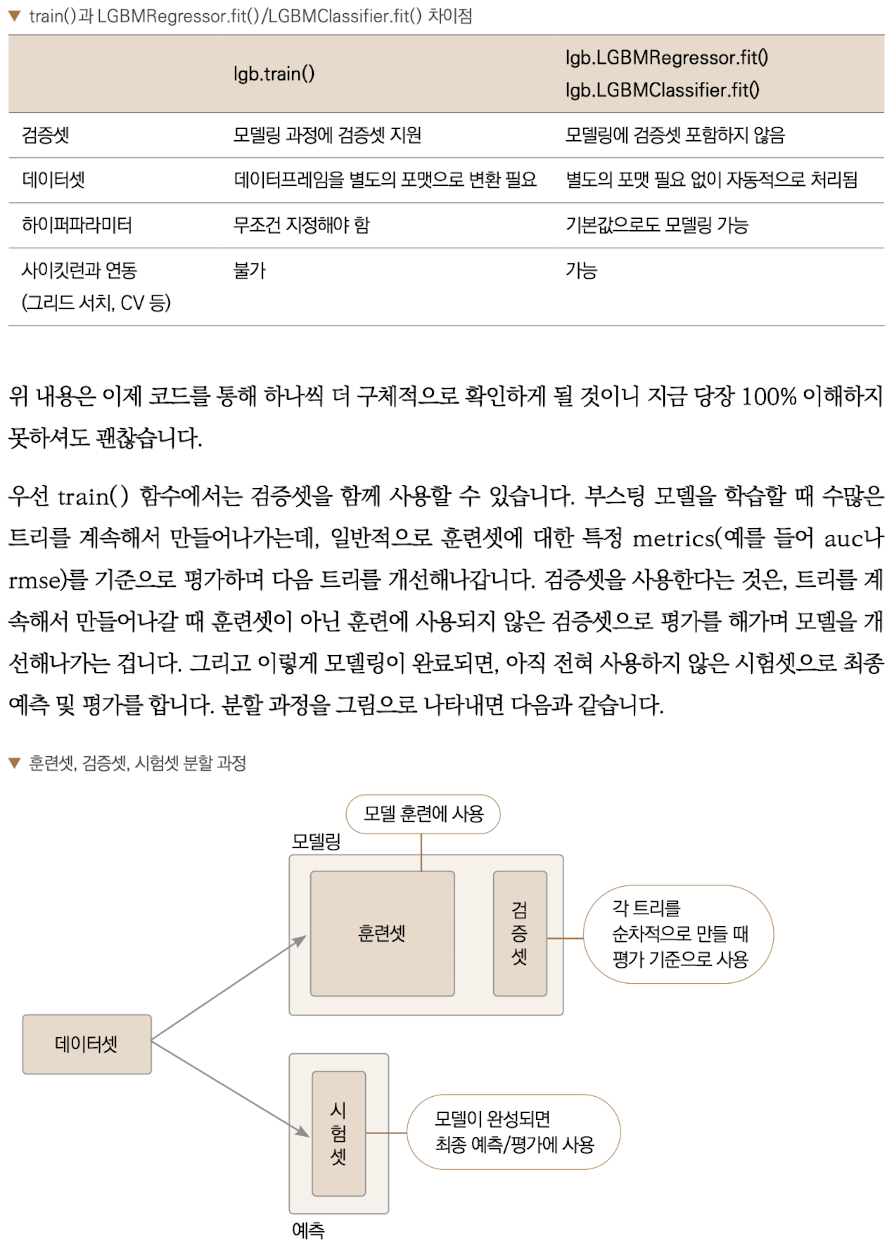

 - lgb.train() 함수에서는 검증셋을 함께 사용할 수 있다
 - 일반적으로 훈련셋에 대한 특정 metrics를 기준으로 평가하며 다음 트리를 개선해 나감
 - 검증셋을 함께 사용하는 경우 검증셋으로 평가를 해가며 다음 트리를 개선해 나감

 - 검증셋은 훈련셋의 일부를 취하여 만들어 냄
 - train_test_split() 함수를 두번 사용하여 세가지 셋(시험/훈련/검증)을 나눔

  > 훈련셋 : 2019년1월~2019년12월
  
  > 검증셋 : 2020년1월~2020년6월

  > 시험셋 : 2020년7월~2020년12월

In [59]:
train = data[data.index < '2020-01-01'] # 훈련셋 설정
val = data[(data.index >= '2020-01-01') & (data.index < '2020-07-01')] # 검증셋 설정
test = data[data.index >= '2020-07-01'] # 시험셋 설정

In [60]:
X_train = train.drop('is_fraud', axis=1)
X_val = val.drop('is_fraud', axis=1)
X_test = test.drop('is_fraud', axis=1)
y_train = train['is_fraud']
y_val = val['is_fraud']
y_test = test['is_fraud']

 - train() 함수로 학습하려면 고유한 데이터셋 형태로 변환 : Dataset() 함수 처리

In [61]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)

 - train() 함수로 학습하려면 함수에 하이퍼파라미터를 입력

In [81]:
# rs.fit()을 통해 구한 best_params_를 train()의 파라미터로 사용할 예정
params_set = rs.best_params_  # rs.fit()을 통해 구한 최적의 하이퍼파라미터
params_set['metrics'] = 'auc' # 평가 기준 추가 : 딕셔너리에 없는 키:값 추가

In [82]:
params_set

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

 - 이제 train() 함수로 훈련 → 결과를 model_3에 저장
 - 모델 객체를 생성한 뒤에 객체.fit()함수로 훈련시키는 LGBMClassifier/Regressor
 - 모델 객체 생성 시점에 lgb.train()함수로 훈련시키는 방법

In [83]:
# 최적의 파라미터를 찾아보는 RandomizedsearchCV()를 직접 사용하지 않고, 이미 알고 있는 최적의 파라미터를 그대로 넣어주는 형식
model_3 = lgb.train(params_set, d_train, valid_sets=[d_val],
                    early_stopping_rounds=100, verbose_eval=100)
# 개선여부에 대한 평가는 valid_sets에서 지정한 검증셋인 d_val에 대한 parmas_set에서 지정한 auc로 결정됨
# 100개의 트리가 더 만들어졌음에도 개선이 되지 않으면 중지
# params_set에서 지정한 n_estimators에 따라 1000개의 트리가 만들어짐
# verbose_eval에 따라 100개 단위로 결과가 출력됨

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.971619
[200]	valid_0's auc: 0.98692
[300]	valid_0's auc: 0.99149
Early stopping, best iteration is:
[299]	valid_0's auc: 0.991501


In [96]:
# 모델 훈련에 시간이 많이 소요되므로 훈련된 모델을 저장/로드
import joblib # 모델 저장을 위한 라이브러리

# 모델 저장
joblib.dump(model_3, '/content/drive/MyDrive/Colab Notebooks/lgb_model_3.pkl') # 모델 저장하기
# 모델 로드
# model_3 = joblib.load('/content/drive/MyDrive/Colab Notebooks/lgb_model_3.pkl') # 

['/content/drive/MyDrive/Colab Notebooks/lgb_model_3.pkl']

 - 299번째 트리에서 가장 좋은 auc
 - 299번째 뒤로 100개의 트리를 더 시도 했으나 개선되지 않아서 멈춤

In [90]:
# 파이썬래퍼를 통해 생성된 모델
# RandomizedsearchCV를 통해 최적의 파라미터를 찾은것이 아니므로 파라미터 확인 또한 attr이 다름
model_3.params

{'subsample': 1,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

 - 학습을 진행했음에도 하이퍼파라미터는 (당연히)변하지 않음
 - RandomizedsearchCV()를 사용하여 최적의 하이퍼파라미터를 찾은 것
 - 최적의 모델을 얻기위해서는 최적의 하이퍼파라미터를 선정하여 훈련(train())을 시켜야 함
 - 훈련 train()을 통해 best_iteration과 그때의 트리를 얻는다

In [92]:
pred_3 = model_3.predict(X_test)

In [94]:
pred_3

array([4.26477000e-04, 5.74992252e-04, 1.20567457e-02, ...,
       1.00416609e+00, 1.06995569e+00, 9.68972162e-01])

 - train() 함수로 훈련된 모델은 predict_proba()역할을 predict()가 대신한다
 - 0과 1이 아닌 소수점 값들을 얻는다

In [95]:
roc_auc_score(y_test, pred_3)

0.9922826067301004

 - LGBMClassifier에 기본적으로 설정된 하이퍼 파라미터의 값과 train()함수에 반영된 기본 하이퍼파라미터 값들의 차이가 있음

 - 검증셋을 나누면서 줄어들게된 훈련셋이 점수에 악영향을 줄 수 있음

 - **사이킷런 래퍼 모듈인 LGBMClassifier/Regressor를 사용하면 사이킷런의 (랜던)그리드서치와 연동되며, 데이터 포맷을 변경할 필요가 없다 → 편리함**

 - **파이썬 래퍼 모듈인 lgb.train()을 사용하면, 검증셋을 활용할 수 있음 → 결과 신뢰도**

 - feature importance 확인시 코드의 차이

  > 사이킷런 래퍼 모듈로 fit()된 모델 :  feature_importances_()

  > 파이썬 래퍼인 모듈로 train()된 모델 : feature_importance()

In [ ]:
feature_imp = pd.DataFrame()